# Developing a logit lens for CLIP

Logit lenses have been a useful interpretability tool for LLMs, but there is not a consistent successful methodology for applying them to CLIP. Instead of getting maximum logits like for an LLM, you are projecting a vector into a shared text-image space and choosing the text vector with the closest cosine similarity.

There are two main issues a) text and images having a rather different representation space that prevents easy translation compared to LLMs, and b) CLIP not having a clear "dictionary matrix," which makes the granularity of labels its own parameter.


### A) Projecting CLIP intermediate representations into the correct semantic space

With language, you can pretty easily feed intermediate representations into the output layer, but the same does not seem to apply for CLIP (you sometimes get random values).

After trying some naive versions in this notebook, I hypothesize that the output space between image and text is too different and simply feeding early representations into the output project is too OOD.

Specifically, I try:

1. Naive logit lens: projecting intermediate representations from the residual stream into the CLIP output.  I also try this for the attn/MLP layers.

2. MLP-only logit lens: I disable the attn layers after the *nth layer* and propagate the tokens through the MLP layers to the final CLS token, with the hope that this projects the tokens into the space, without distorting the semantics of each token too much (there are intra-token transformations but not inter-token transformations via attention).

### B): Constructing the appropriate "dictionary" for CLIP

Finally, I play with labels for the logits. Unlike vision, CLIP does not have a fixed directionary matrix but was trained on the entire internet of captioned images. Thus the expressivity of the logits becomes its own parameter. We can treat the logits as 1000-way ImageNet-1k classification, or we can treat the logits as a bank of captions. 

If we try a larger caption bank, then perhaps intermediate representations will be labeled in a way that's more granular, and we will be able to see phenomena like door + window + wall = house, or eye + ear = face.

In [ ]:
# Load data
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Subset
import os
import logging
import json
import random

import numpy as np
import json
from tqdm.notebook import tqdm

# Load imagenet


# Path to your imagenet_class.json file
json_file_path = '/home/mila/s/sonia.joseph/ViT-Planetarium/my_draft/test_nbs/imagenet_class_index.json'
imagenet_path = '/network/datasets/imagenet.var/imagenet_torchvision/val/'

# Get class names
# imagenet_class_nums = np.arange(0, 1000, 1)
# imagenet_class_names = ["{}".format(get_class_name(i)) for i in imagenet_class_nums]

# Set the seed. You don't need indices if data is loaded in same order every time.
seed = 42
torch.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)

data_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])

# # Load the ImageNet dataset
# imagenet_data = datasets.ImageFolder(imagenet_path, transform=data_transforms)


In [2]:
import pandas as pd
import os

layer_num = 7

save_path = f'/network/scratch/s/sonia.joseph/clip_mechinterp/tinyclip/mini_dataset/'
file_name = f'mlp_fc1_{layer_num}.npz'

loaded = pd.read_parquet(os.path.join(save_path, file_name))


In [3]:
# Load imagenet


# Path to your imagenet_class.json file
json_file_path = '/home/mila/s/sonia.joseph/ViT-Planetarium/my_draft/test_nbs/imagenet_class_index.json'
imagenet_path = '/network/datasets/imagenet.var/imagenet_torchvision/val/'

# Load the JSON file into a Python dictionary
with open(json_file_path, 'r') as file:
    num_to_word_dict = json.load(file)

# Create a reverse dictionary for word to number mapping
word_to_num_dict = {}
for num, words in num_to_word_dict.items():
    for word in words:  # Assuming each entry in num_to_word_dict is a list of words
        word_to_num_dict[word] = num

# Function to get the class name from a label
def get_class_name(label):
    # Assuming the label maps to a list of class names
    return num_to_word_dict.get(str(label), ["Unknown label"])[1]

# Function to get the label from a class name
def get_label(class_name):
    return word_to_num_dict.get(class_name, "Unknown class name")

# Get class names
imagenet_class_nums = np.arange(0, 1000, 1)
imagenet_class_names = ["{}".format(get_class_name(i)) for i in imagenet_class_nums]
print(imagenet_class_names)

# Set the seed. You don't need indices if data is loaded in same order every time.
seed = 42
torch.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)

data_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])

# Function to load images based on saved order
def load_images_in_order(indices_path, imagenet_dataset):
    indices = np.load(indices_path)
    subset_dataset = Subset(imagenet_dataset, indices)
    data_loader = DataLoader(subset_dataset, batch_size=1)
    return data_loader

# Load the ImageNet dataset
batch_size = 1
imagenet_data = datasets.ImageFolder(imagenet_path, transform=data_transforms)
data_loader = load_images_in_order('imagenet_sample_indices.npy', imagenet_data)


['tench', 'goldfish', 'great_white_shark', 'tiger_shark', 'hammerhead', 'electric_ray', 'stingray', 'cock', 'hen', 'ostrich', 'brambling', 'goldfinch', 'house_finch', 'junco', 'indigo_bunting', 'robin', 'bulbul', 'jay', 'magpie', 'chickadee', 'water_ouzel', 'kite', 'bald_eagle', 'vulture', 'great_grey_owl', 'European_fire_salamander', 'common_newt', 'eft', 'spotted_salamander', 'axolotl', 'bullfrog', 'tree_frog', 'tailed_frog', 'loggerhead', 'leatherback_turtle', 'mud_turtle', 'terrapin', 'box_turtle', 'banded_gecko', 'common_iguana', 'American_chameleon', 'whiptail', 'agama', 'frilled_lizard', 'alligator_lizard', 'Gila_monster', 'green_lizard', 'African_chameleon', 'Komodo_dragon', 'African_crocodile', 'American_alligator', 'triceratops', 'thunder_snake', 'ringneck_snake', 'hognose_snake', 'green_snake', 'king_snake', 'garter_snake', 'water_snake', 'vine_snake', 'night_snake', 'boa_constrictor', 'rock_python', 'Indian_cobra', 'green_mamba', 'sea_snake', 'horned_viper', 'diamondback', 

`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["id2label"]` will be overriden.
`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["id2label"]` will be overriden.


Text(0.5, 1.0, 'Predicted: mountain_bike. True: mountain_bike')

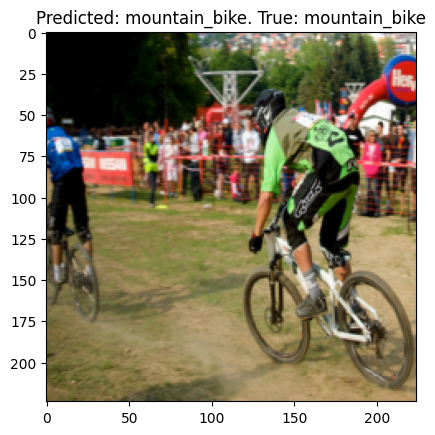

In [4]:
# Get CLIP 
from PIL import Image
import requests
import matplotlib.pyplot as plt

from transformers import CLIPProcessor, CLIPModel

model = CLIPModel.from_pretrained("wkcn/TinyCLIP-ViT-8M-16-Text-3M-YFCC15M")
processor = CLIPProcessor.from_pretrained("wkcn/TinyCLIP-ViT-8M-16-Text-3M-YFCC15M", do_rescale=False) # Make sure the do_rescale is false for pytorch datasets

count = 0
MAX_COUNT = 1
for images, labels in data_loader:
    inputs = processor(text=imagenet_class_names, images=images, return_tensors="pt", padding=True)
    count += 1
    if count == MAX_COUNT:
        break

idx = 0
outputs = model(**inputs)
logits_per_image = outputs.logits_per_image # this is the image-text similarity score
probs = logits_per_image.softmax(dim=1) # we can take the softmax to get the label probabilities
# predicted_class = imagenet_class_names[probs.argmax(dim=1)]
predicted_indices = probs.argmax(dim=1)

plt.imshow(images[0].permute(1, 2, 0))
plt.title(f"Predicted: {get_class_name(predicted_indices[idx].item())}. True: {get_class_name(labels[idx].item())}")

## Run linear probe

In [5]:

# Hook function to capture output of each layer
def get_activations(name, activations):
    def hook(model, input, output):
        activations[name] = output
    return hook



In [6]:
import torch


# Assuming 'model' is your CLIP model
activations = {}
hooks = []

for layer_idx, layer in enumerate(model.vision_model.encoder.layers):
   for submodule_name, submodule in layer.named_children():
        # Create a unique name for each submodule
        name = f"layer_{layer_idx}_{submodule_name}"
        hook = submodule.register_forward_hook(get_activations(name, activations))
        hooks.append(hook)
    
hook = model.vision_model.post_layernorm.register_forward_hook(get_activations("post_layernorm", activations))

hooks.append(hook)
   
# Run a forward pass with your data
# Replace 'input_data' with your actual input tensor
output = model(**inputs)

# Now 'activations' will have the outputs of each layer
# ... (use the activations for your purpose)

# Detach the hooks after use
for hook in hooks:
    hook.remove()


In [7]:
import torch

def get_layer_activations(name, activations):
    def hook(model, input, output):
        activations[name] = output
    return hook

# Assuming 'model' is your CLIP model
activations = {}
hooks = []

# Register hooks on encoder layers
for layer_idx, layer in enumerate(model.vision_model.encoder.layers):
    hook = layer.register_forward_hook(get_activations(f"encoder_layer_{layer_idx}", activations))
    hooks.append(hook)

# Optionally, register a hook on the final layer after all encoder layers
hook = model.vision_model.post_layernorm.register_forward_hook(get_layer_activations("post_layernorm", activations))
hooks.append(hook)

# Run a forward pass with your data
# Replace 'inputs' with your actual input tensor
output = model(**inputs)

# Now 'activations' will have the outputs of each layer
# ... (use the activations for your purpose)

# Detach the hooks after use
for hook in hooks:
    hook.remove()


In [8]:
# Get original text similarity score
text_embeddings = output['text_embeds']
print(activations.keys())

dict_keys(['encoder_layer_0', 'encoder_layer_1', 'encoder_layer_2', 'encoder_layer_3', 'encoder_layer_4', 'encoder_layer_5', 'encoder_layer_6', 'encoder_layer_7', 'encoder_layer_8', 'encoder_layer_9', 'post_layernorm'])


In [9]:
import torch
import torch.nn.functional as F

# Assuming 'image_patches' is your image patch embeddings tensor of size [1, 197, 512]
# And 'text_embeddings' is your text embeddings tensor of size [1000, 512]

# Feed MLP layers into CLIP encoder

act = activations['layer_8_layer_norm2'][0] 
# act = model.vision_model.post_layernorm(act)
vis_emb = model.visual_projection(act)
image_patches = vis_emb

last_layer = True

if last_layer:
    image_patches = vis_emb 
else:
    image_patches = vis_emb.squeeze(0)  # Now it's [197, 512]

# # # Normalize the embeddings
# norm_image_patches = F.normalize(image_patches, p=2, dim=1)
# norm_text_embeddings = F.normalize(text_embeddings, p=2, dim=1)

# Compute cosine similarities
# The shape of 'cosine_sim' will be [197, 1000], representing the similarity 
# between each image patch and each text embedding
cosine_sim = torch.matmul(image_patches, text_embeddings.T)
print('cosin_sim', cosine_sim.shape)
probs = cosine_sim.softmax(dim=1) # we can take the softmax to get the label probabilities
pred_labels = probs.argmax(dim=1)
# Now, 'cosine_sim[i, j]' is the cosine similarity between the i-th image patch and the j-th text embedding


KeyError: 'layer_8_layer_norm2'

In [ ]:
# Apply post_layernorm to every patch, not just CLS token
act = activations['encoder_layer_9'][0]
act = model.vision_model.post_layernorm(act)
vis_emb = model.visual_projection(act)
# image_patches = vis_emb
image_patches = vis_emb.squeeze(0)  # Now it's [197, 512]

# Normalize the embeddings
image_patches = F.normalize(image_patches, p=2, dim=1)
text_embeddings = F.normalize(text_embeddings, p=2, dim=1)

cosine_sim = torch.matmul(image_patches, text_embeddings.T)
print(cosine_sim.shape)
probs = cosine_sim.softmax(dim=1) # we can take the softmax to get the label probabilities
pred_labels = probs.argmax(dim=1)

# Now, 'cosine_sim[i, j]' is the cosine similarity between the i-th image patch and the j-th text embedding


torch.Size([197, 1000])


In [ ]:
for idx, label in enumerate(pred_labels):
    print(idx, imagenet_class_names[label.item()])

0 mountain_bike
1 screen
2 scoreboard
3 scoreboard
4 pole
5 screen
6 iron
7 screen
8 screen
9 jay
10 screen
11 scoreboard
12 pole
13 screen
14 screen
15 scoreboard
16 scoreboard
17 screen
18 scoreboard
19 pole
20 screen
21 screen
22 screen
23 scoreboard
24 quill
25 screen
26 pole
27 screen
28 jay
29 jay
30 scoreboard
31 screen
32 jay
33 tick
34 robin
35 pole
36 pole
37 pole
38 screen
39 screen
40 screen
41 beacon
42 jay
43 alp
44 hen
45 jay
46 cliff
47 scale
48 scale
49 jay
50 maraca
51 alp
52 alp
53 pole
54 pole
55 pole
56 alp
57 screen
58 screen
59 screen
60 scale
61 scale
62 screen
63 jay
64 alp
65 pole
66 pole
67 pole
68 alp
69 jay
70 alp
71 pole
72 jay
73 jay
74 alp
75 jay
76 alp
77 alp
78 alp
79 pole
80 orange
81 pole
82 pole
83 jay
84 jay
85 pole
86 alp
87 maraca
88 jay
89 pole
90 jay
91 jay
92 bicycle-built-for-two
93 alp
94 pole
95 pole
96 pole
97 mountain_bike
98 alp
99 pole
100 pole
101 jay
102 alp
103 jay
104 jay
105 jay
106 alp
107 pole
108 pole
109 pole
110 pole
111 jay
1

Text(0.5, 1.0, 'CLS token is hartebeest')

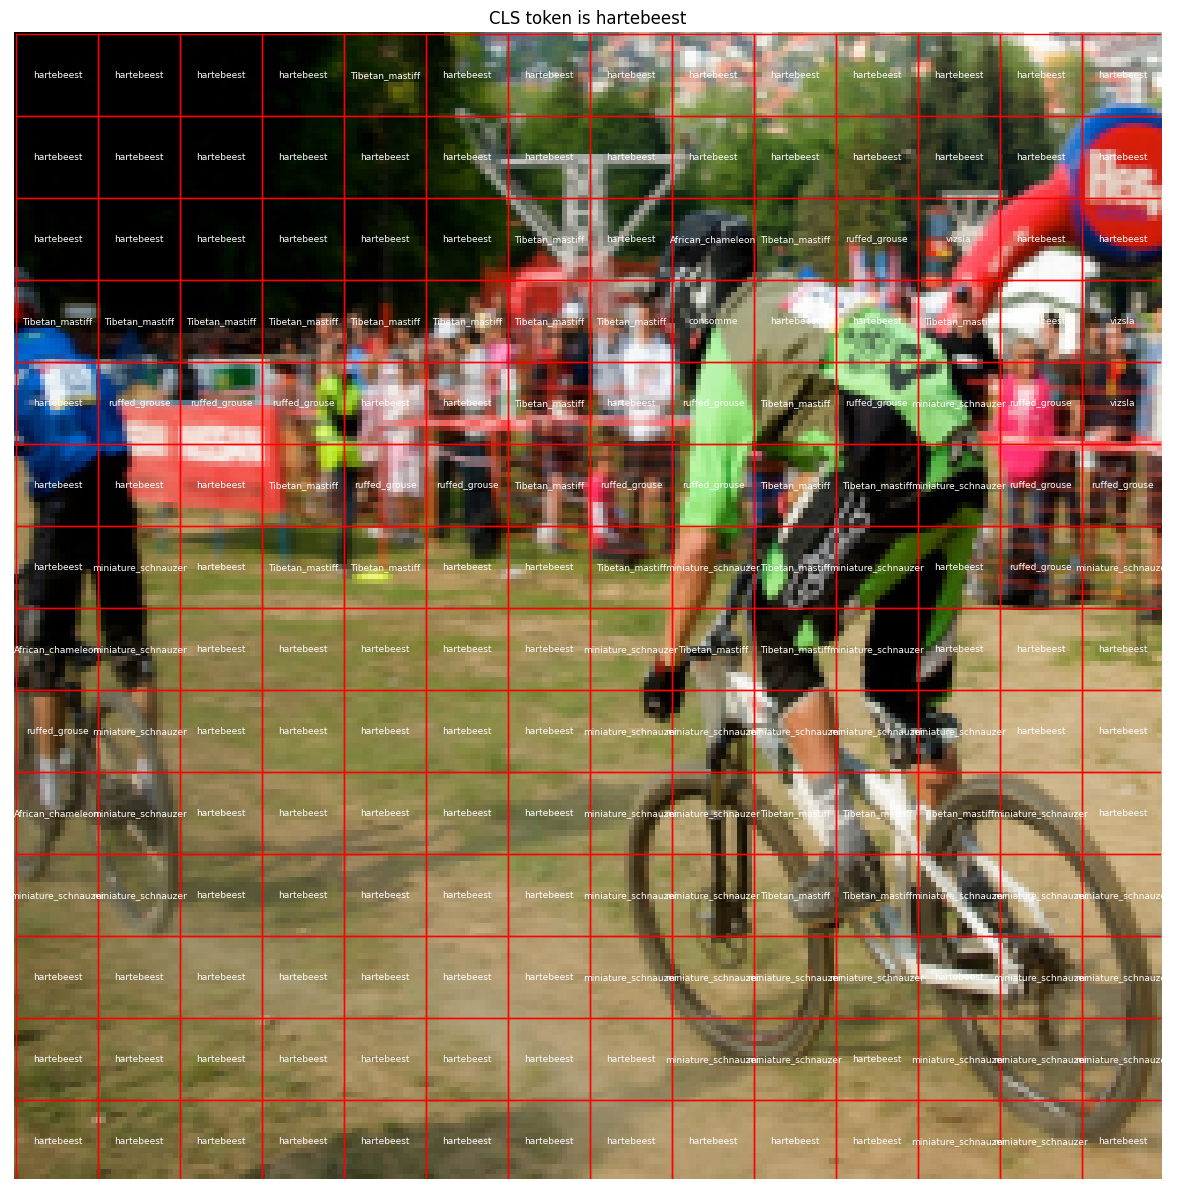

In [ ]:
# I will use Python to overlay the given labels on an image, simulating a grid of 196 patches.
# For simplicity, let's assume the image is to be divided into a 14x14 grid (since 14*14 = 196).
# The labels will be overlaid on the corresponding patches.

import matplotlib.pyplot as plt
import matplotlib.patches as patches
from PIL import Image
import numpy as np

# Load the image
# image_path = '/mnt/data/Screen Shot 2023-12-25 at 11.59.08 PM.png'
# image = Image.open(image_path)
image_array = images[0].permute(1, 2, 0).numpy()

# Define the grid size and labels
grid_size = (14, 14) # Since 14*14 = 196

# Calculate the patch size
patch_width = image_array.shape[1] // grid_size[1]
patch_height = image_array.shape[0] // grid_size[0]

# Create a figure and axis to plot the image
fig, ax = plt.subplots(figsize=(12, 12))
ax.imshow(image_array)

# Function to get the patch position
def get_patch_position(index, grid_size, patch_width, patch_height):
    row = index // grid_size[1]
    col = index % grid_size[1]
    return col * patch_width, row * patch_height

# Overlay labels on the image
for i, label_idx in enumerate(pred_labels[1:], start=1): # skip CLS token
    label = get_class_name(label_idx.item())
    x, y = get_patch_position(i-1, grid_size, patch_width, patch_height)
    rect = patches.Rectangle((x, y), patch_width, patch_height, linewidth=1, edgecolor='r', facecolor='none')
    ax.add_patch(rect)
    plt.text(x + patch_width/2, y + patch_height/2, label, color='white', fontsize=6.5, ha='center', va='center')

cls_token = get_class_name(pred_labels[0].item())

# Remove axis for clarity
plt.axis('off')
plt.tight_layout()

# Save the resulting image
# output_path = '/mnt/data/annotated_image.png'
# plt.savefig(output_path)
plt.title(f"CLS token is {cls_token}")

# Return the path to the annotated image
# output_path
